In [14]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

from enum import Enum
from typing import Any, List
from utils import *

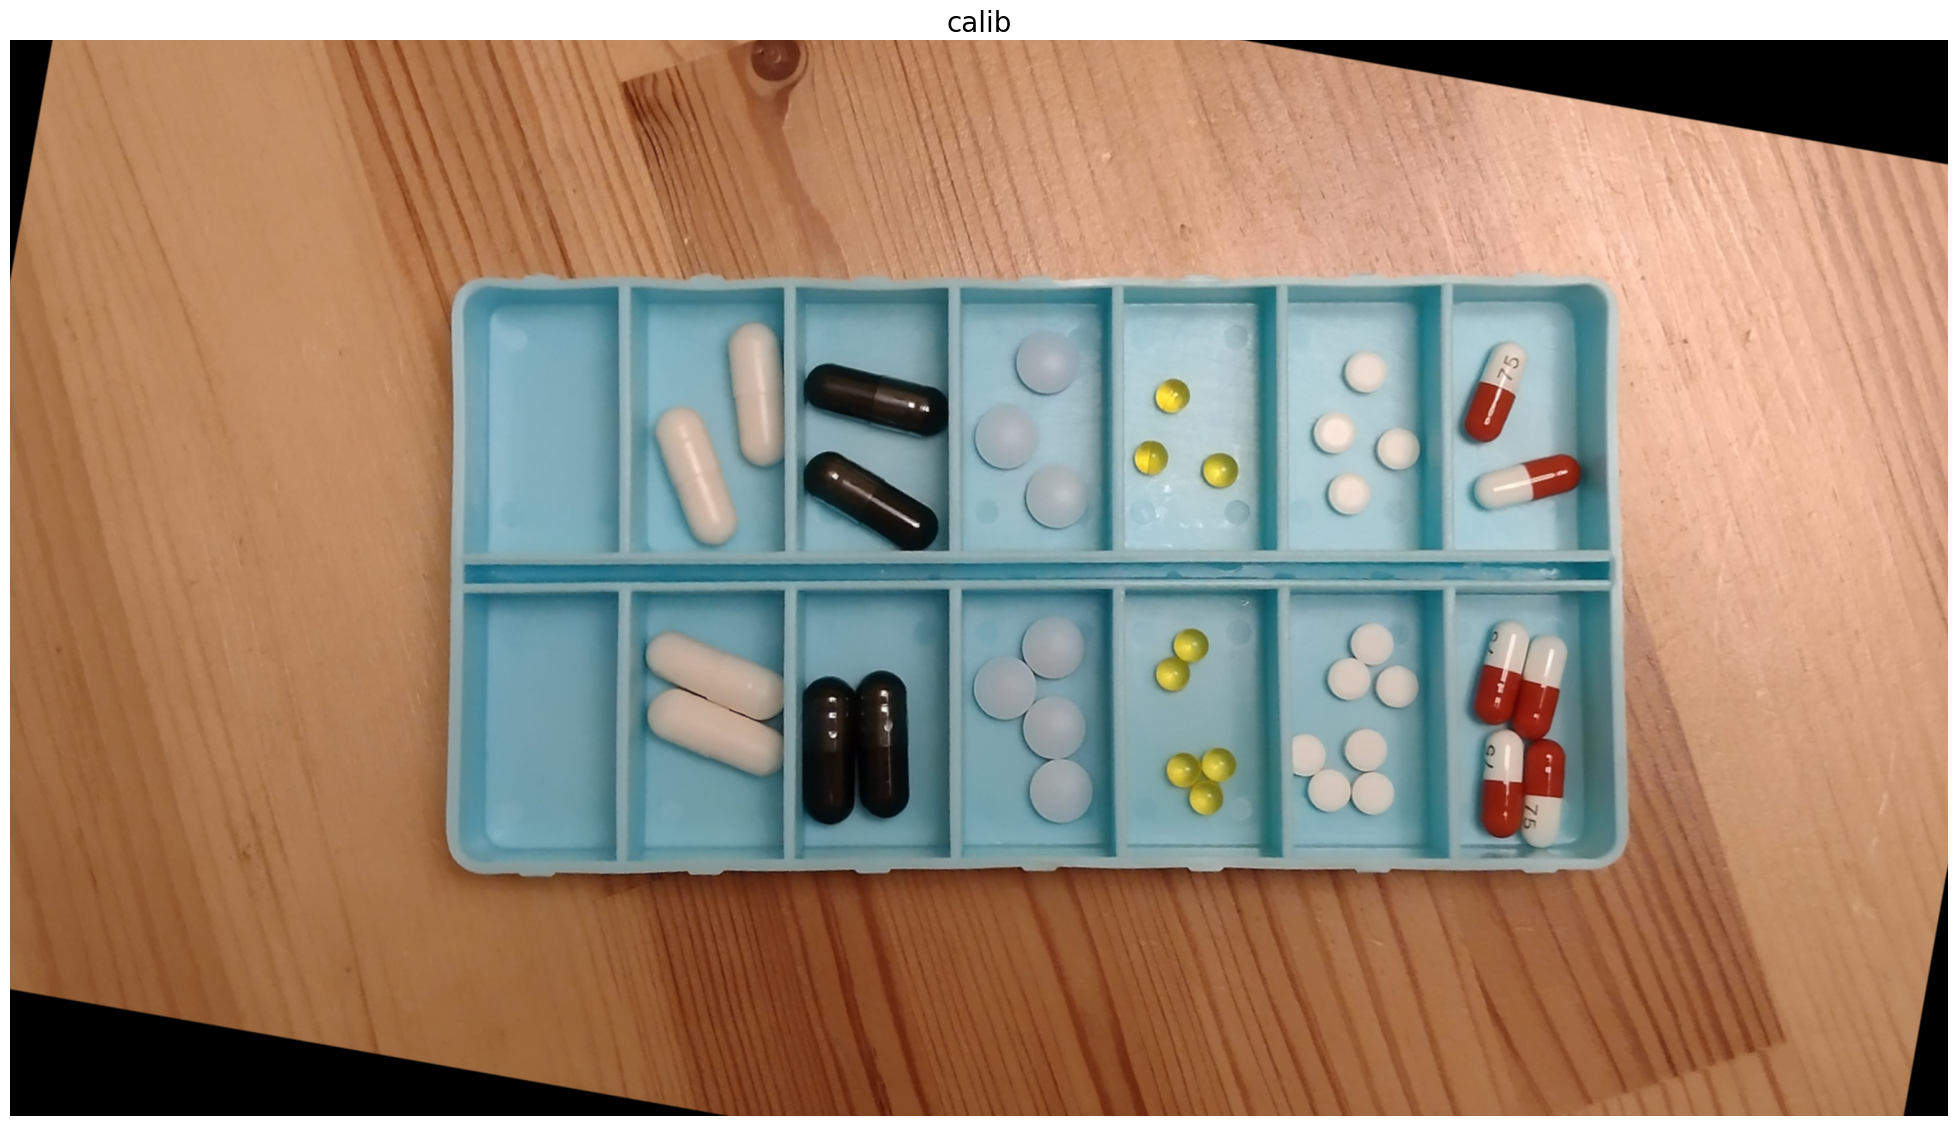

In [15]:
calib = cv2.cvtColor(cv2.imread('images/calib.png'), cv2.COLOR_BGR2RGB)
calib = crop_box(calib, angel=-10)
display_images([calib], ['calib'])

In [16]:
calib = cv2.imread('images/calib.png')
calib = crop_box(calib, angel=-10)
calib_hsv = cv2.cvtColor(calib, cv2.COLOR_BGR2HSV)
calib_lab = cv2.cvtColor(calib, cv2.COLOR_BGR2LAB)
test = cv2.imread('images/test.png')
test = crop_box(test, angel=21)

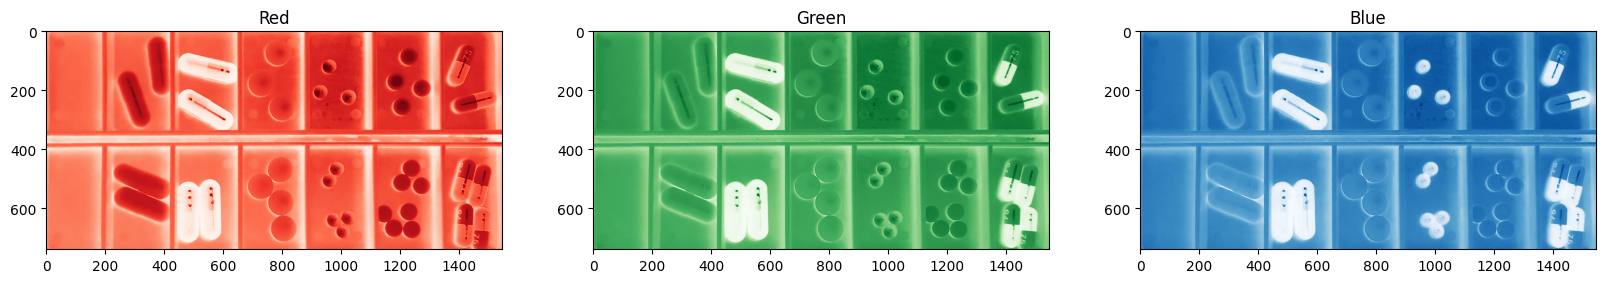

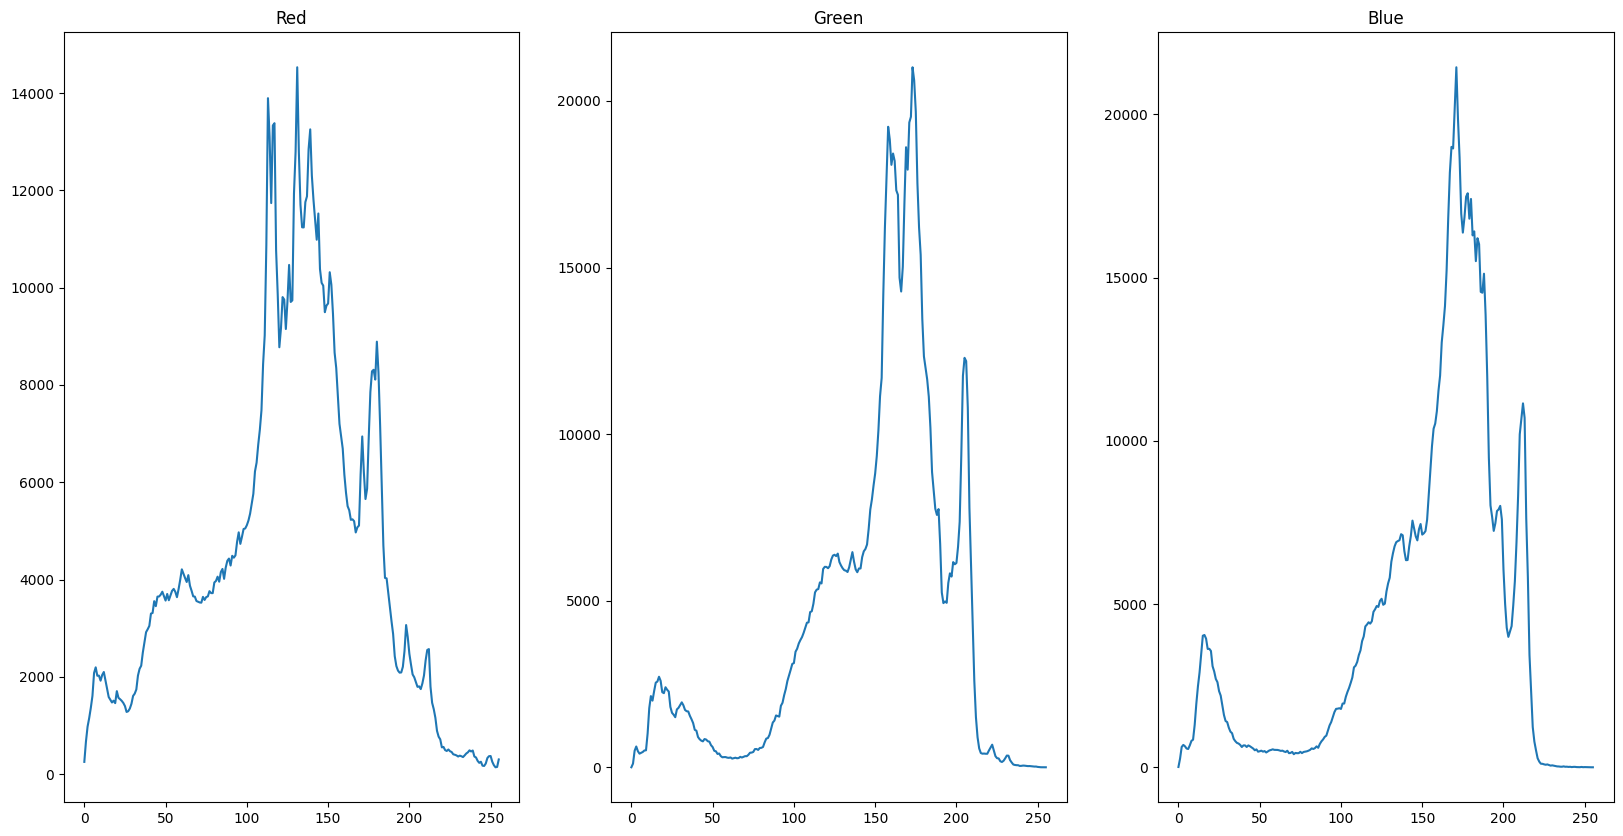

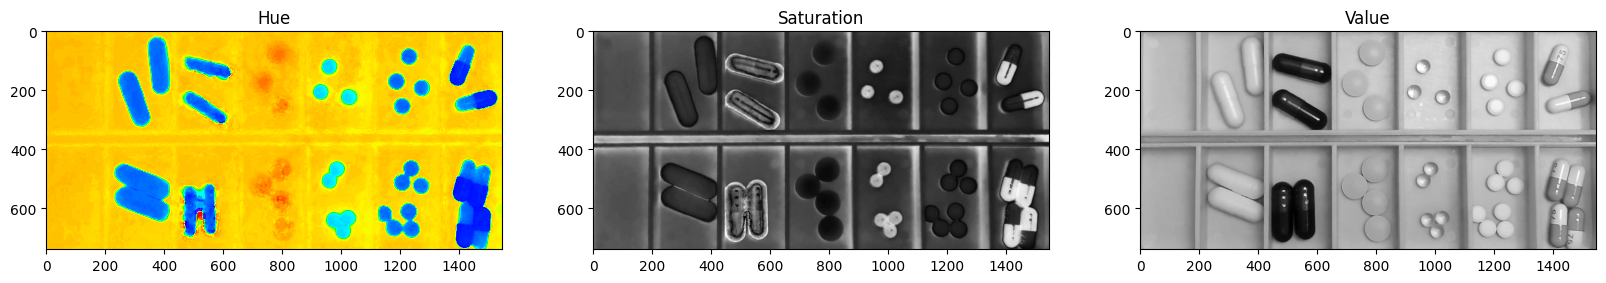

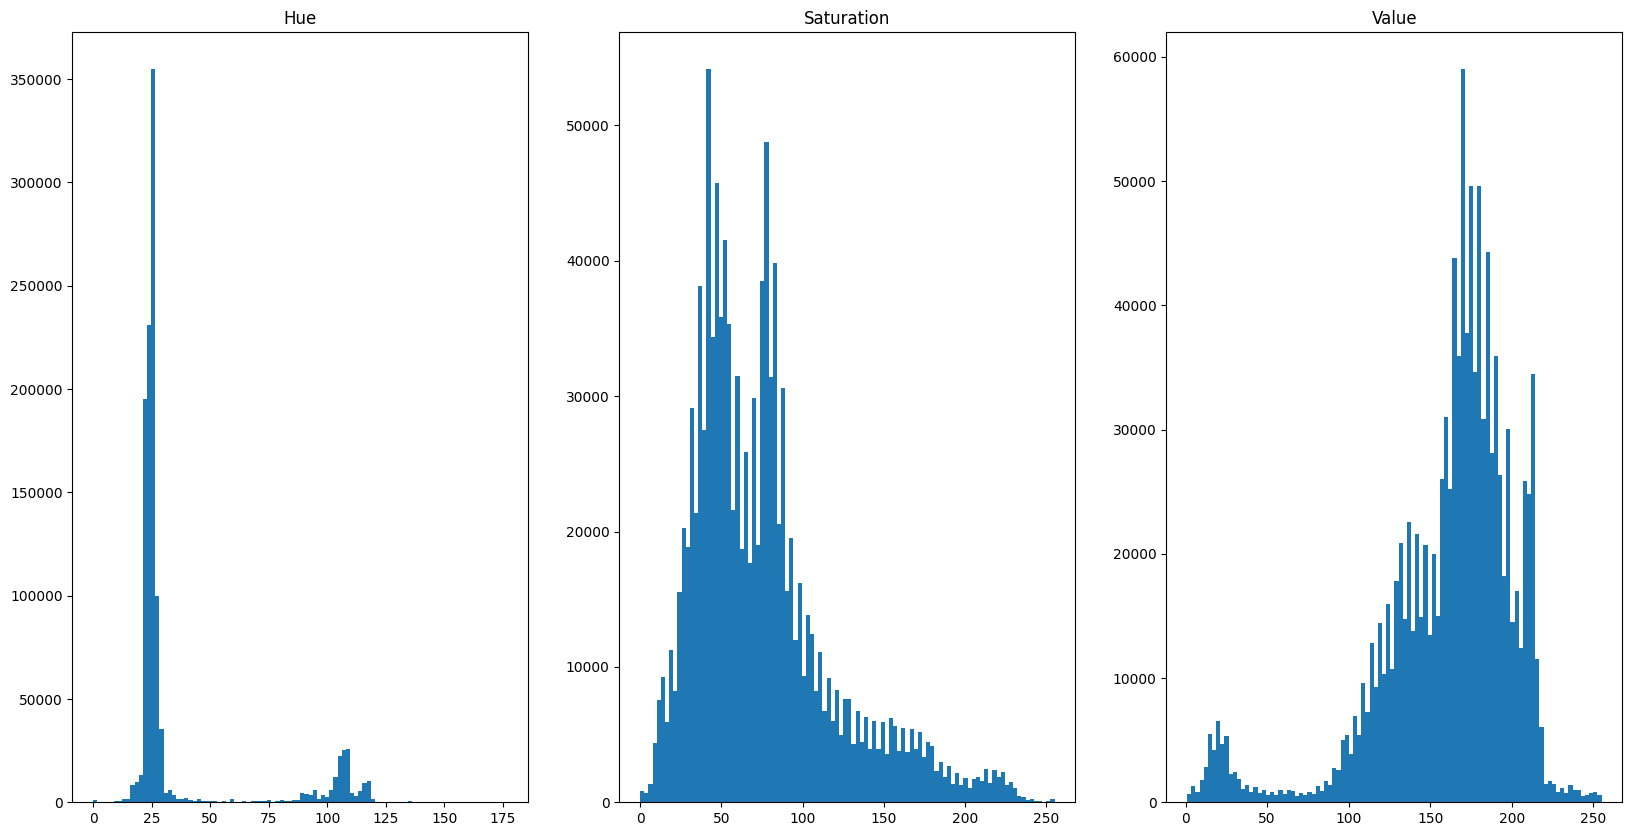

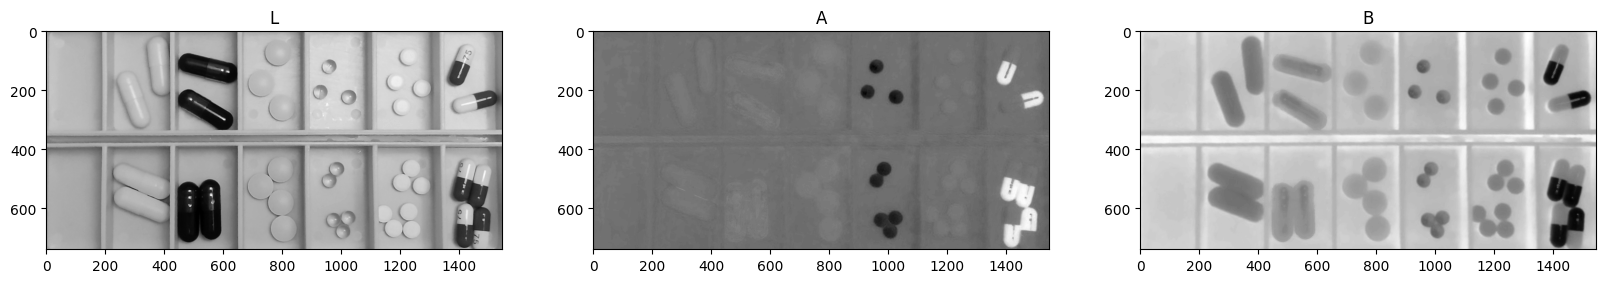

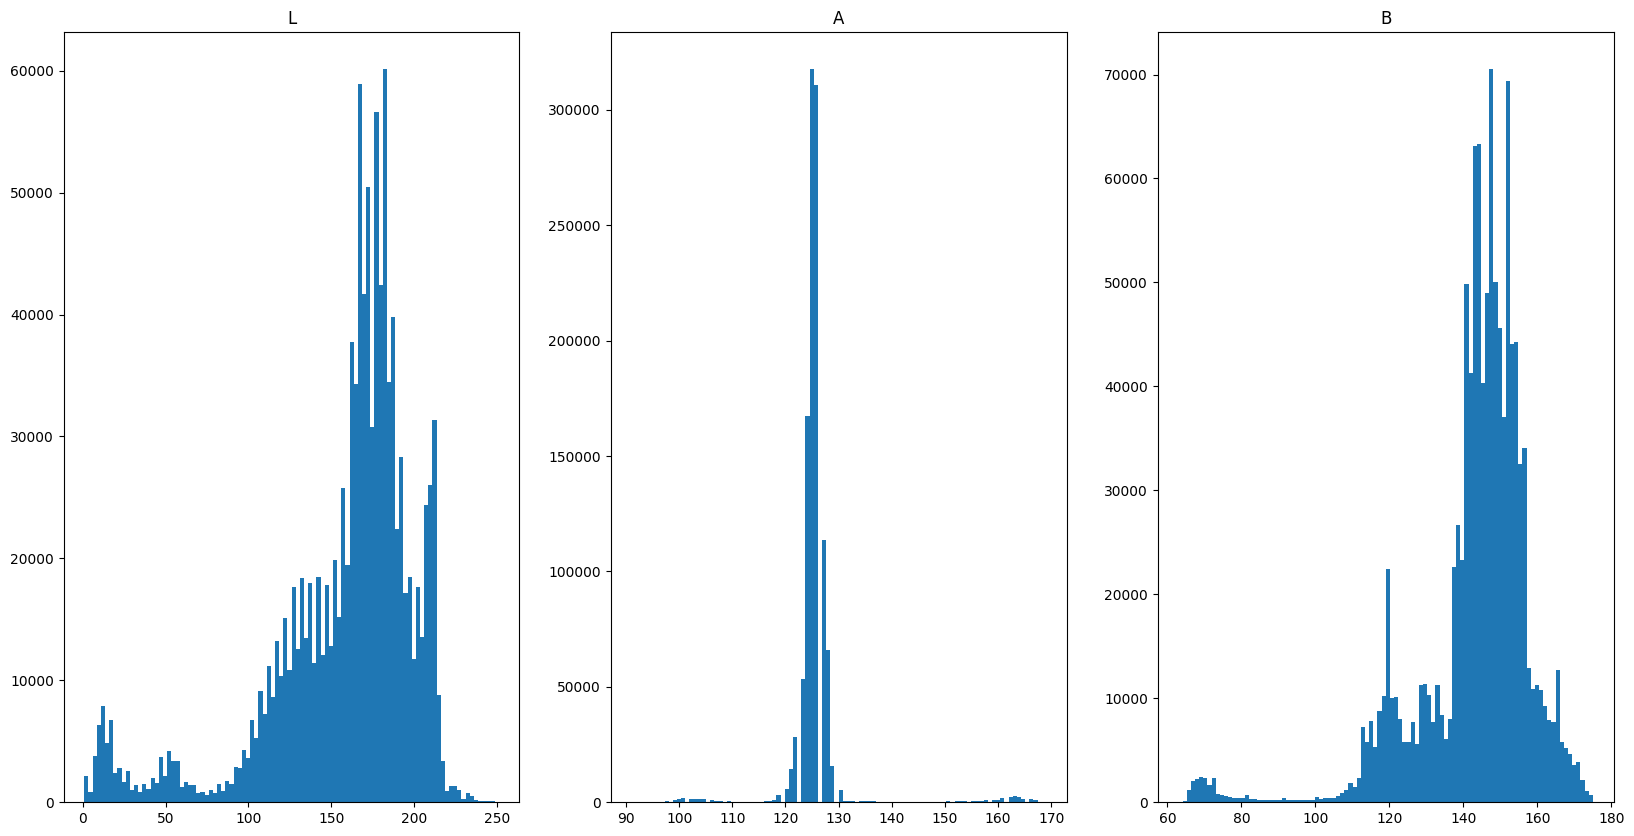

In [17]:
analyze_channels(calib, calib_lab, calib_hsv)

64.0


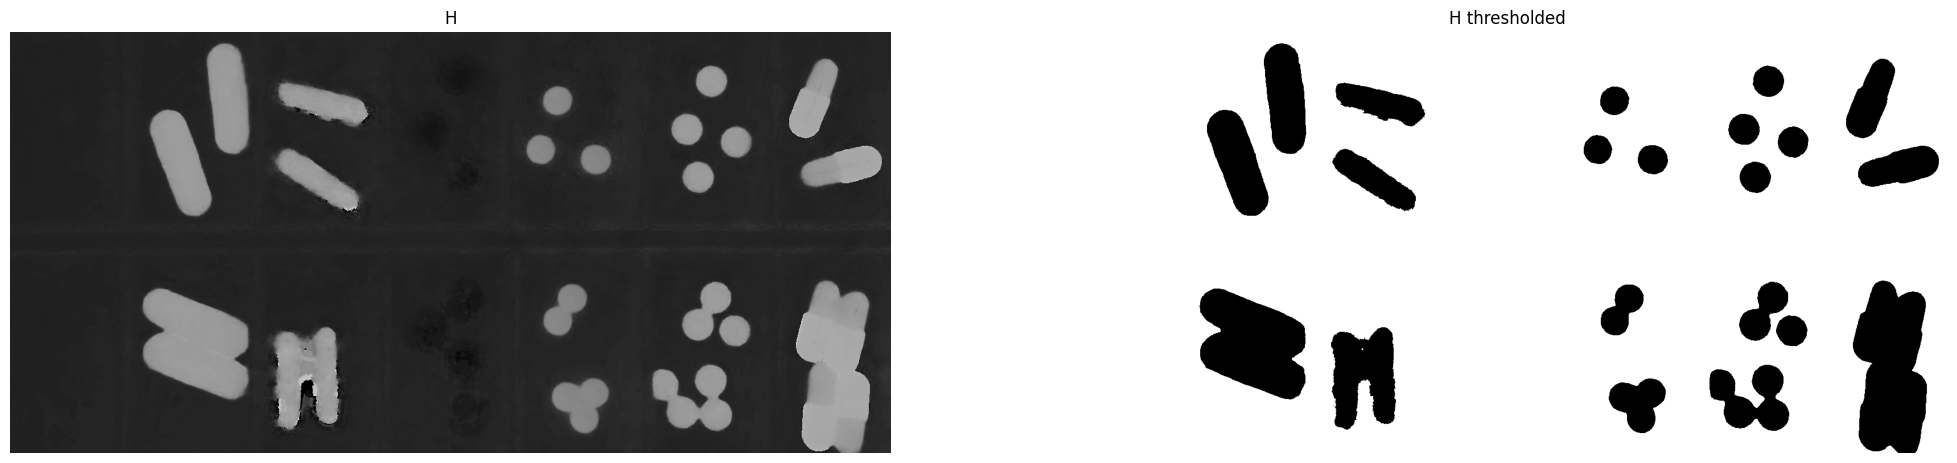

In [18]:
H, S, V = cv2.split(calib_hsv)
# global thresholding
ret1,th1 = cv2.threshold(H,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
print(ret1)
display_images([H, th1], ['H', 'H thresholded'], True)

75.0


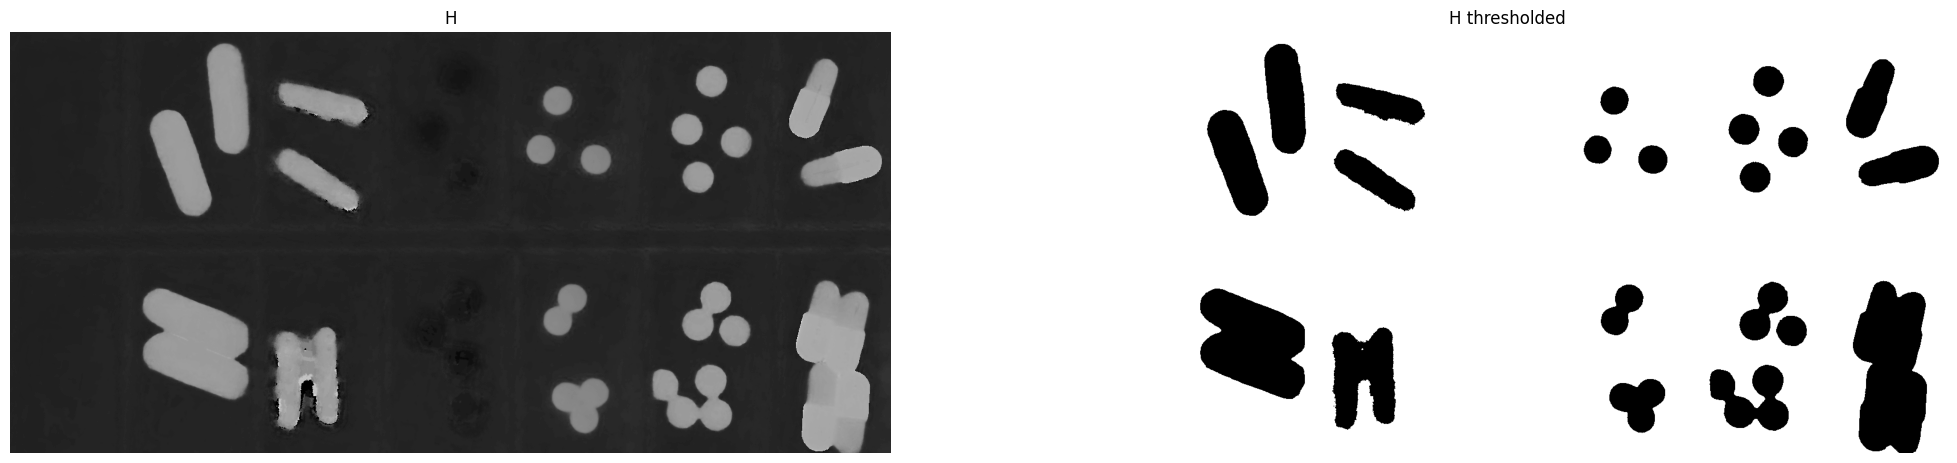

In [19]:
H, S, V = cv2.split(calib_hsv)
# global thresholding
ret1,th1 = cv2.threshold(H,75,255,cv2.THRESH_BINARY_INV)
print(ret1)
display_images([H, th1], ['H', 'H thresholded'], True)

In [20]:
def get_mask_pills(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    H, S, V = cv2.split(hsv)
    ret1,th1 = cv2.threshold(H,80,255,cv2.THRESH_BINARY_INV)
    return th1

In [21]:
def get_mask_espu(img, morph=True, kernel_size=3, iterations=1, thresh_val=180):
    img_lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(img_lab)
    ret, thresh = cv2.threshold(b, thresh_val, 255, cv2.THRESH_BINARY_INV)

    if morph:
        kernel = np.ones((kernel_size, kernel_size), np.uint8)
        thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=iterations)
    return thresh

In [22]:
def blue_xy(img):
    L, A, B = cv2.split(cv2.cvtColor(img, cv2.COLOR_BGR2LAB))
    ret1,th1 = cv2.threshold(A,165,255,cv2.THRESH_BINARY)
    kernel = np.ones((3,3), np.uint8)
    erode = cv2.erode(th1, kernel, iterations=3)
    close  = erode
    # close = cv2.morphologyEx(erode, cv2.MORPH_CLOSE, kernel, iterations=1)
    contours = cv2.findContours(close, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)[0]
    contours = [c for c in contours if (len(c) > 5 and cv2.contourArea(c) > 300)]
    blue_xy = []
    for c in contours:
        # feat elipses
        ellipse = cv2.fitEllipse(c)
        x, y = ellipse[0]
        blue_xy.append((x, y))
    return blue_xy


In [23]:
def detect_whites(img):
    img = cv2.GaussianBlur(img, (1,1), 0)
    mask = get_mask_pills(img)
    result = apply_mask(img, mask)
    
    L, A, B = cv2.split(cv2.cvtColor(result, cv2.COLOR_BGR2LAB))
    ret1,th1 = cv2.threshold(L,125,255,cv2.THRESH_BINARY)
    espu = get_mask_espu(img)
    result2 = apply_mask(th1, espu)
    kernel = np.ones((3,3), np.uint8)
    result2 = cv2.morphologyEx(result2, cv2.MORPH_OPEN, kernel, iterations=11)
    # erode 
    kernel = np.ones((3,3), np.uint8)
    result2 = cv2.erode(result2, kernel, iterations=13)
    # morpho close
    kernel = np.ones((1,1), np.uint8)
    result2 = cv2.morphologyEx(result2, cv2.MORPH_CLOSE, kernel, iterations=1)
    # result2 = cv2.distanceTransform(result2, cv2.DIST_L2, 5)
    # result2 = cv2.normalize(result2, result2, 0, 1.0, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    return result2

In [24]:
def calculate_aspect_ratio(ellipse):
    len1, len2 = ellipse[1]
    return len1 / len2

In [25]:
def detect_biox_probio(img):
    w = detect_whites(img)
    # display_images([w], ['whites'], True)
    # contours
    contours, hierarchy = cv2.findContours(w, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    # feat elipses
    ellipses = []
    for c in contours:
        if len(c) > 5: 
            ellipse = cv2.fitEllipse(c)
            ellipses.append(ellipse)
    # draw ellipses
    result = img.copy()
    bluexy = blue_xy(img)
    
    for e in ellipses:
        text = str(calculate_aspect_ratio(e))   
        area = cv2.contourArea(c)
        x, y = e[0]
        if any([abs(np.linalg.norm(np.array([x, y]) - np.array([bx, by]))) < 90 for bx, by in bluexy]):
            continue
        if calculate_aspect_ratio(e) > 0.4:
            cv2.ellipse(result, e, (0, 255, 0), 2)
            cv2.putText(result, text, (int(e[0][0]), int(e[0][1])), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)
        if calculate_aspect_ratio(e) < 0.3:
            cv2.ellipse(result, e, (0, 0, 255), 2)
            cv2.putText(result, text, (int(e[0][0]), int(e[0][1])), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)
    display_images([result], ['result'], True)


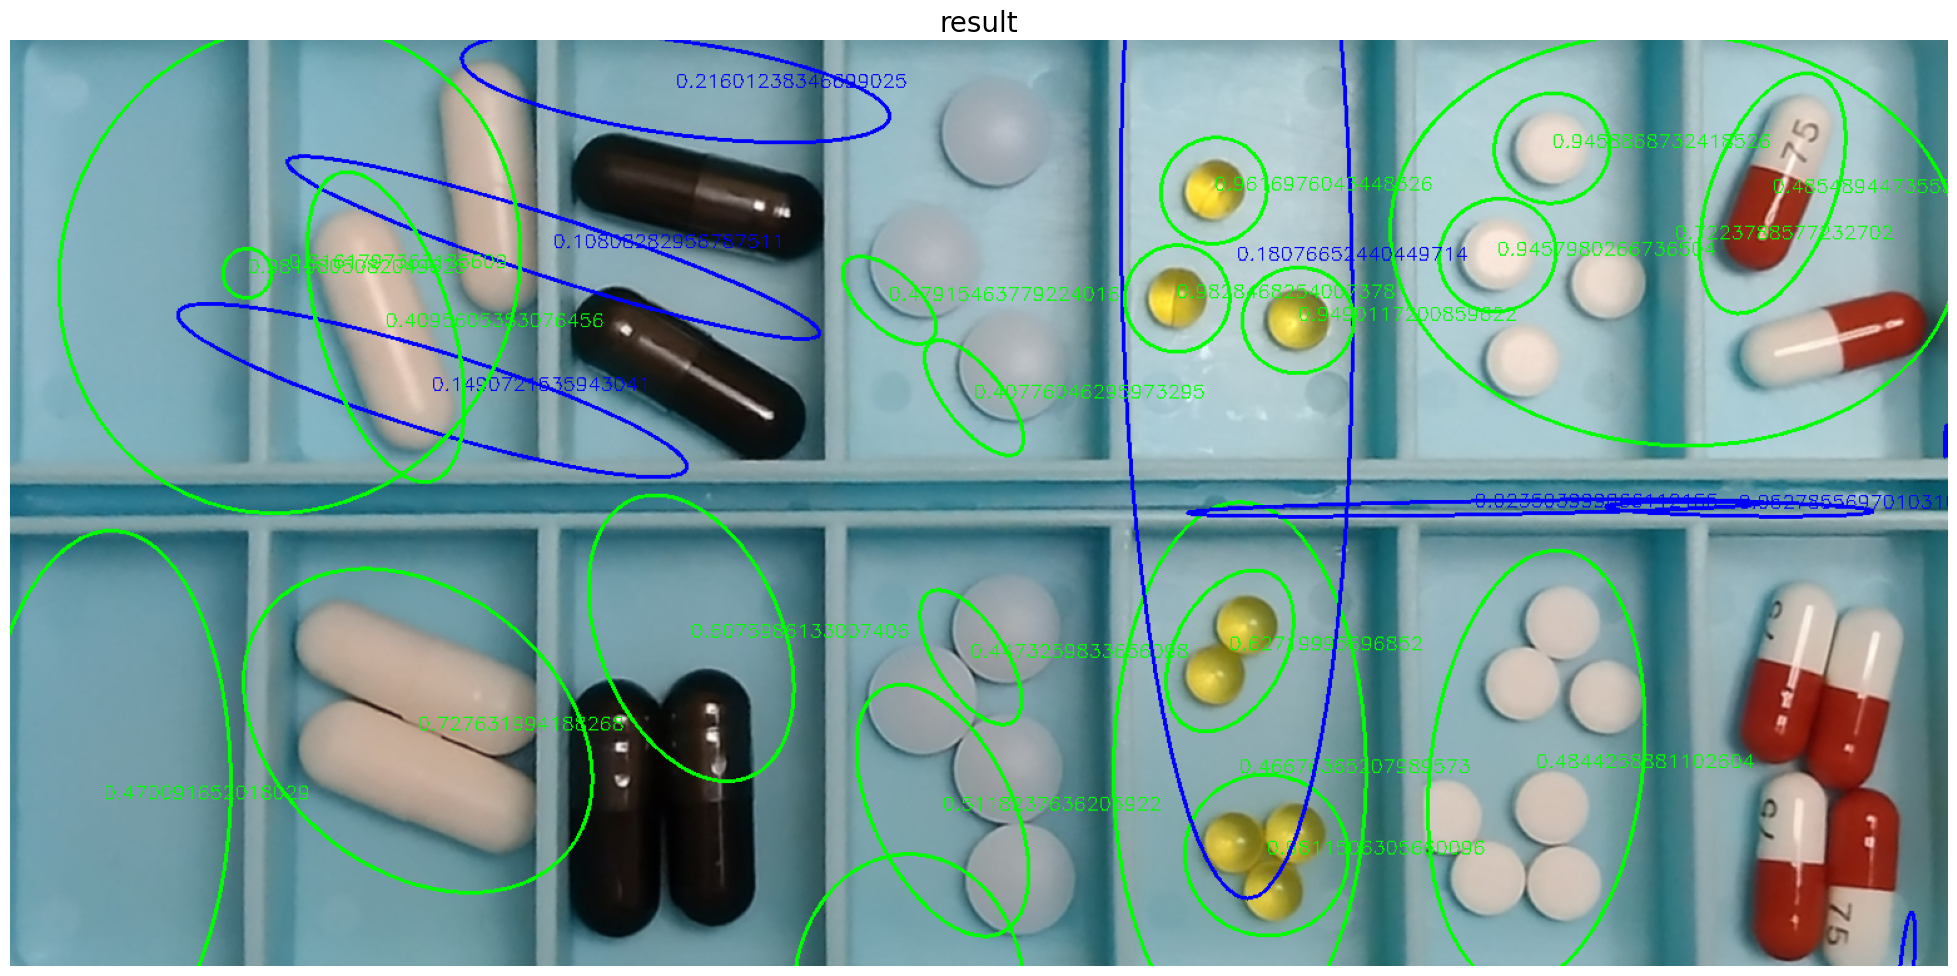

In [26]:
detect_biox_probio(calib)